In [6]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3
import pyvista as pv
import sys
import os
import flopy as fp

# auto reload modules
%load_ext autoreload
%autoreload 2
# 
sys.path.append("M:/Github/ArchPy/")
# sys.path.append("../../../../../Documents/Github/ArchPy/")
#my modules
from ArchPy.base import *
from ArchPy.tpgs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
Table = ArchPy.inputs.import_project("P1", "ArchPy_workspace")

### IMPORTING PROJECT P1 IN ArchPy_workspace DIRECTORY ### 

Unit A: Surface added for interpolation
Facies basement added to unit A
Unit B: Surface added for interpolation
Facies Sand added to unit B
Facies Gravel added to unit B
Facies Clay added to unit B
Unit C: Surface added for interpolation
Facies Clay added to unit C
Unit D: Surface added for interpolation
Facies Sand added to unit D
Stratigraphic unit D added
Stratigraphic unit C added
Stratigraphic unit B added
Stratigraphic unit A added
Pile sets as Pile master
Property K added
Property Porosity added
Property long_disp added
## Adding Grid ##
## Grid added and is now simulation grid ##


 ##LOADING RESULTS## 


Unit results file not found
Facies results file not found
Property results file not found
#### Surfaces loaded ####
#### Bottom surfaces loaded ####


 ### SUCCESSFUL IMPORT ### 



## Flow

### Total budget

In [8]:
def get_cum_total(sim_ws):
    sim= fp.mf6.MFSimulation.load(sim_name="sim_test",sim_ws=sim_ws, verbosity_level=0)
    gwf = sim.get_model("test")
    f = gwf.output.list().get_cumulative()
    return f.TOTAL_IN[0], f.TOTAL_OUT[0]

In [9]:
sim= fp.mf6.MFSimulation.load(sim_name="sim_test",sim_ws="layered_hetero", verbosity_level=0)
gwf = sim.get_model("test")
f = gwf.output.list()

In [10]:
f.get_cumulative()

rec.array([(1.15741e-05, 0, 0, 0.0015, 0., 0.0027958, 0., 0.0042958, 0., 0.0015, 0., 0.0027956, 0.0042956, 2.2287e-07, 0.01, 0.)],
          dtype=[('totim', '<f4'), ('time_step', '<i4'), ('stress_period', '<i4'), ('WEL_IN', '<f4'), ('WEL2_IN', '<f4'), ('CHD_IN', '<f4'), ('CHD2_IN', '<f4'), ('TOTAL_IN', '<f4'), ('WEL_OUT', '<f4'), ('WEL2_OUT', '<f4'), ('CHD_OUT', '<f4'), ('CHD2_OUT', '<f4'), ('TOTAL_OUT', '<f4'), ('IN-OUT', '<f4'), ('PERCENT_DISCREPANCY', '<f4'), ('tslen', '<f4')])

In [11]:
print(get_cum_total("layered_hetero"))
print(get_cum_total("layered_homo"))
print(get_cum_total("archpy_mode_hetero"))
print(get_cum_total("archpy_mode_homo"))
print(get_cum_total("new_res_hetero"))
print(get_cum_total("modflow_grid_hetero"))

(0.0042958, 0.0042956)
(0.0039802, 0.0039807)
(0.003954, 0.0039541)
(0.0038601, 0.0038637)
(0.0034765, 0.0034776)
(0.0038881, 0.003888)


### Flux sums

In [12]:
def get_cum_qxqyqz(sim_ws):
    sim= fp.mf6.MFSimulation.load(sim_name="sim_test",sim_ws=sim_ws, verbosity_level=0)
    gwf = sim.get_model("test")
    cobj = gwf.output.budget()
    qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)
    return np.nansum(qx), np.nansum(qy), np.nansum(qz)


def get_mean_qxqyqz(sim_ws):
    sim= fp.mf6.MFSimulation.load(sim_name="sim_test",sim_ws=sim_ws, verbosity_level=0)
    gwf = sim.get_model("test")
    cobj = gwf.output.budget()
    qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)
    return np.nanmean(qx), np.nanmean(qy), np.nanmean(qz)

In [13]:
modes = ["layered_hetero", "layered_homo", "archpy_mode_homo", "archpy_mode_hetero", "new_res_hetero", "modflow_grid_hetero"]

In [14]:
df = pd.DataFrame()

for mode in modes:
    
    qx, qy, qz = get_cum_qxqyqz(mode)
    df_i = pd.DataFrame({"qx":qx, "qy":qy, "qz":qz}, index=[mode])
    df = pd.concat([df, df_i], axis=0)

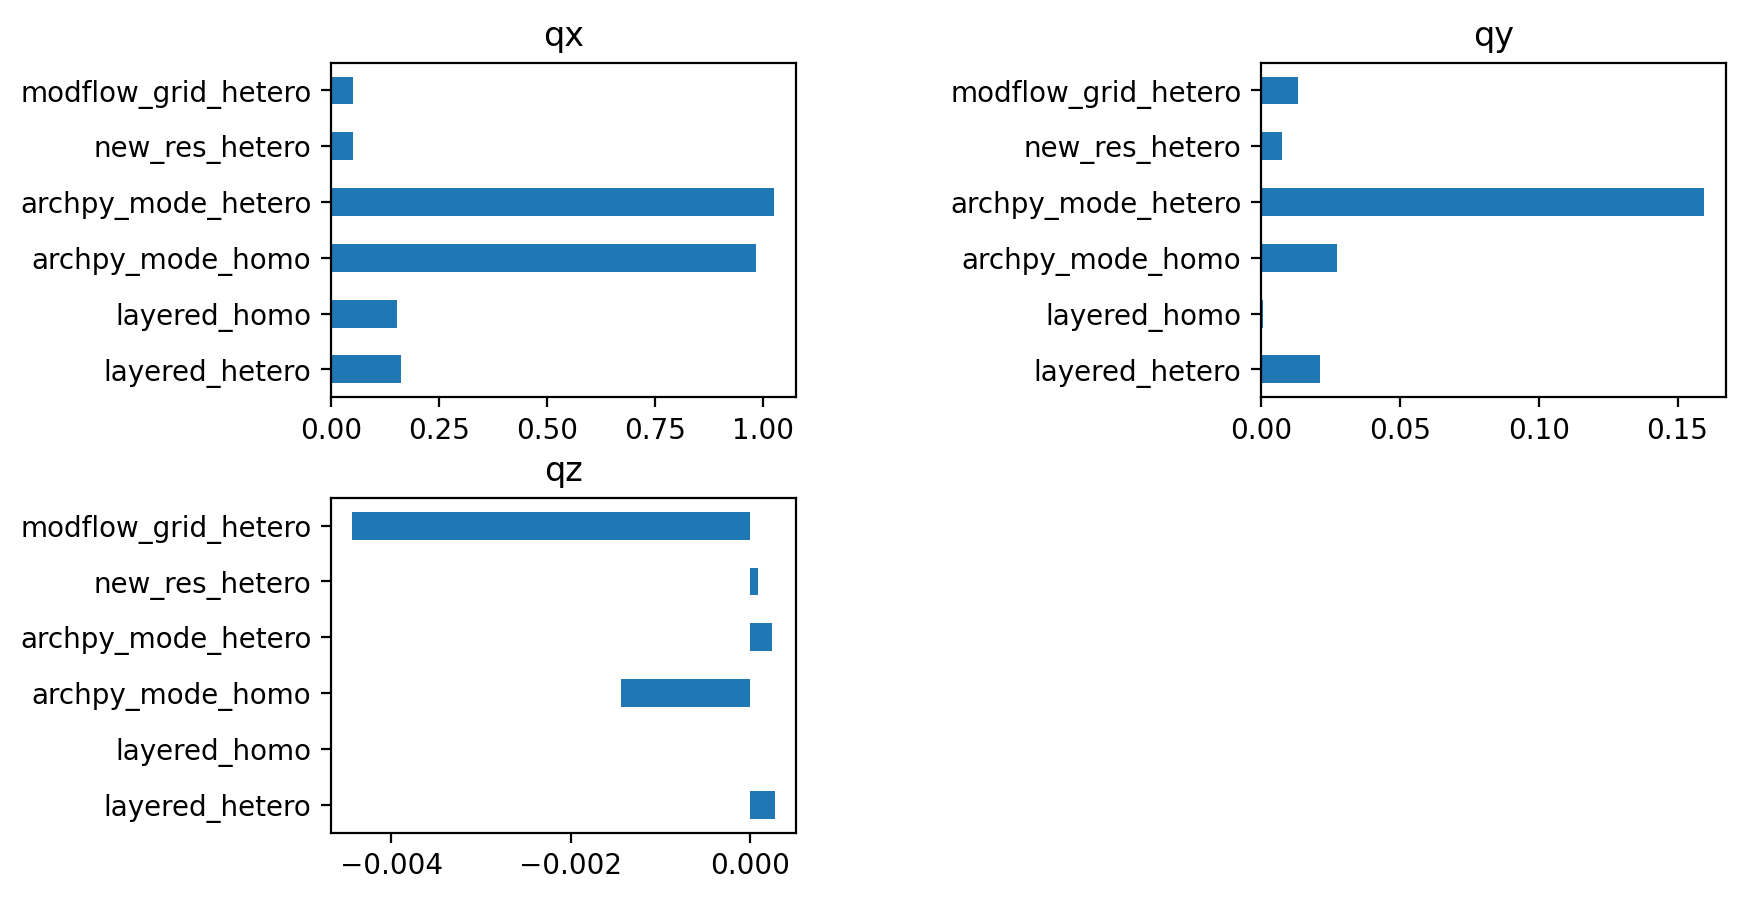

In [15]:
plt.figure(figsize=(9, 5), dpi=200) 

plt.subplot(2, 2, 1)
df.qx.plot.barh()
plt.title("qx")
plt.subplot(2, 2, 2)
df.qy.plot.barh()
plt.title("qy")
plt.subplot(2, 2, 3)
df.qz.plot.barh()
plt.title("qz")

plt.subplots_adjust(wspace=1, hspace=0.3)

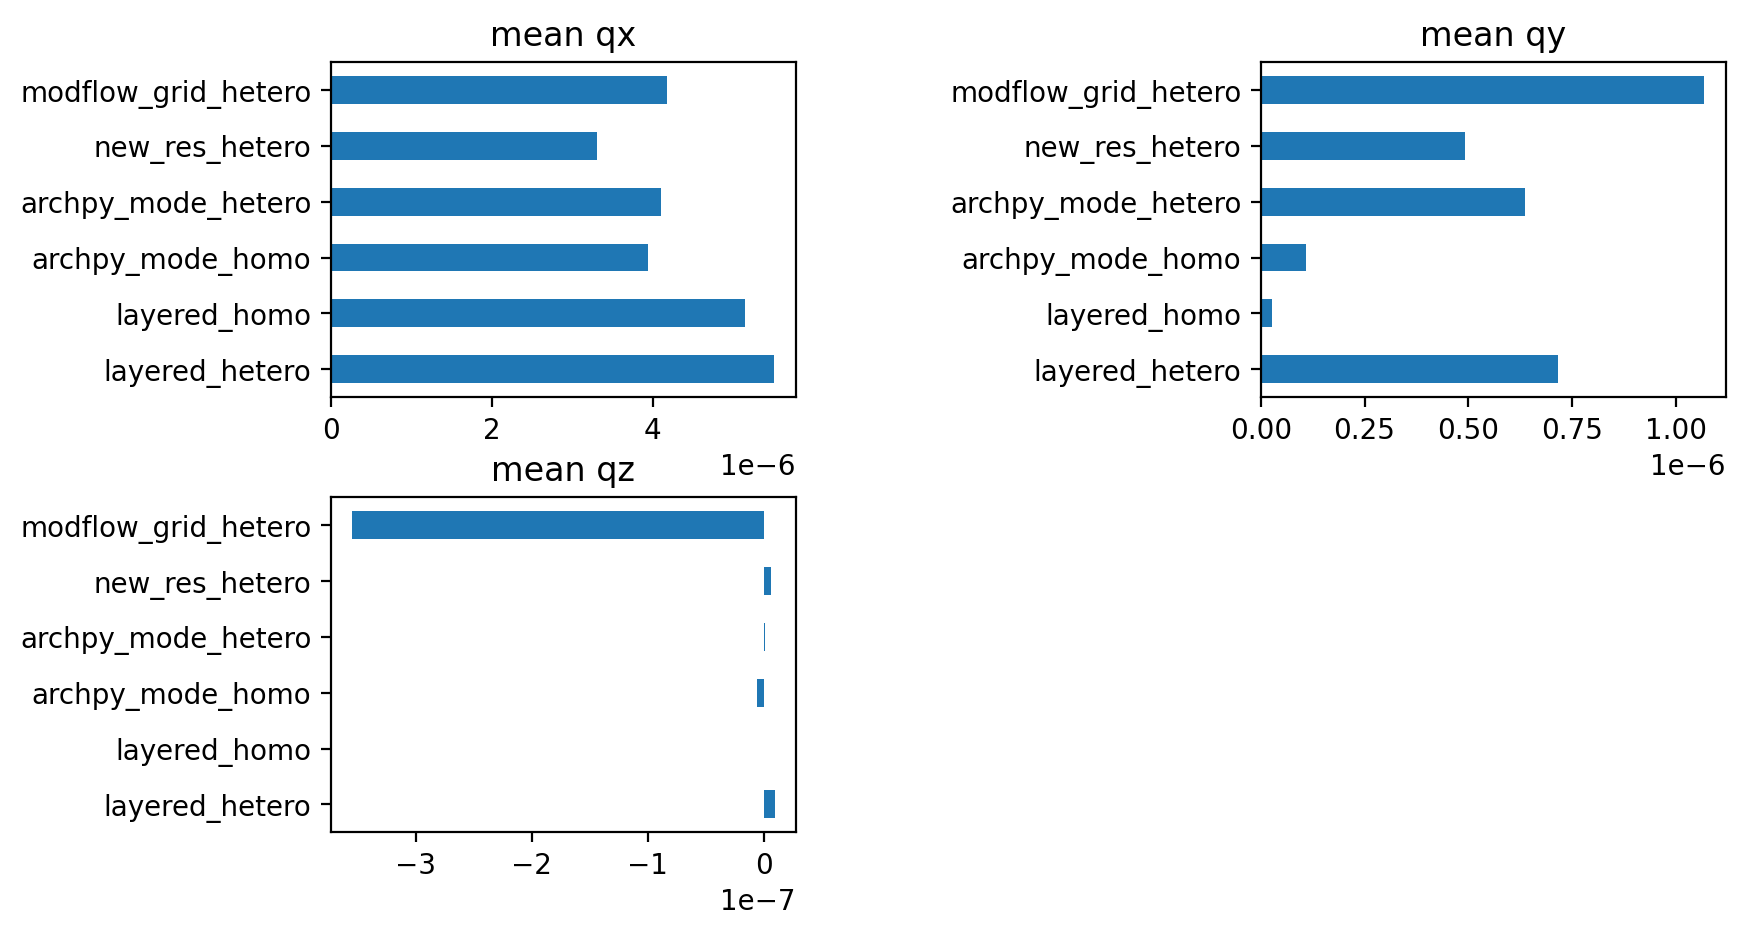

In [16]:
df = pd.DataFrame()

for mode in modes:
        
        qx, qy, qz = get_mean_qxqyqz(mode)
        df_i = pd.DataFrame({"qx":qx, "qy":qy, "qz":qz}, index=[mode])
        df = pd.concat([df, df_i], axis=0)
plt.figure(figsize=(9, 5), dpi=200)
plt.subplot(2, 2, 1)
df.qx.plot.barh()
plt.title("mean qx")
plt.subplot(2, 2, 2)
df.qy.plot.barh()
plt.title("mean qy")
plt.subplot(2, 2, 3)
df.qz.plot.barh()
plt.title("mean qz")
plt.subplots_adjust(wspace=1, hspace=0.3)

### Flux vectors

In [17]:
sim= fp.mf6.MFSimulation.load(sim_name="sim_test",sim_ws="archpy_mode_hetero", verbosity_level=0)
gwf = sim.get_model("test")
cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
    cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

In [18]:
# averaged per layers for the reference
mask_units = np.load("results/mask_units.npy")
l = []

for ilay in range(len(mask_units)):
    qx_copy = qx.copy()
    mask_lay = np.flipud(np.flip(mask_units[ilay], axis=1))
    qx_copy[~mask_lay] = np.nan
    qx_averaged = np.nanmean(qx_copy, axis=0)

    l.append(qx_averaged)
qx_averaged_per_layers = np.array(l)

# qy
l = []
for ilay in range(len(mask_units)):
    qx_copy = qy.copy()
    mask_lay = np.flipud(np.flip(mask_units[ilay], axis=1))
    qx_copy[~mask_lay] = np.nan
    qx_averaged = np.nanmean(qx_copy, axis=0)

    l.append(qx_averaged)
qy_averaged_per_layers = np.array(l)

# qz
l = []
for ilay in range(len(mask_units)):
    qx_copy = qz.copy()
    mask_lay = np.flipud(np.flip(mask_units[ilay], axis=1))
    qx_copy[~mask_lay] = np.nan
    qx_averaged = np.nanmean(qx_copy, axis=0)

    l.append(qx_averaged)
qz_averaged_per_layers = np.array(l)

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

sim= fp.mf6.MFSimulation.load(sim_name="sim_test",sim_ws="layered_homo", verbosity_level=0)
gwf = sim.get_model("test")
cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
    cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

# compare water flow vectors between two models
X = np.array([qx.flatten(), qy.flatten(), qz.flatten()]).T
Y = np.array([qx_averaged_per_layers.flatten(), qy_averaged_per_layers.flatten(), qz_averaged_per_layers.flatten()]).T

# remove NaN values
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(Y).any(axis=1)
X = X[mask]
Y = Y[mask]

# calculate cosine similarity
cosine_sim_homo = cosine_similarity(X, Y)
print(np.mean(cosine_sim_homo.diagonal()))
del cosine_sim_homo

# euclidean distance
euclidean_distance_homo = np.linalg.norm(X - Y, axis=1)


## Layered hetero
sim= fp.mf6.MFSimulation.load(sim_name="sim_test",sim_ws="layered_hetero", verbosity_level=0)
gwf = sim.get_model("test")
cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
    cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

# compare water flow vectors between two models
X = np.array([qx.flatten(), qy.flatten(), qz.flatten()]).T
Y = np.array([qx_averaged_per_layers.flatten(), qy_averaged_per_layers.flatten(), qz_averaged_per_layers.flatten()]).T

# remove NaN values
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(Y).any(axis=1)
X = X[mask]
Y = Y[mask]

# calculate cosine similarity
cosine_sim_hetero = cosine_similarity(X, Y)
print(np.mean(cosine_sim_hetero.diagonal()))
del cosine_sim_hetero

# euclidean distance
euclidean_distance_hetero = np.linalg.norm(X - Y, axis=1)

## archpy homo
sim= fp.mf6.MFSimulation.load(sim_name="sim_test",sim_ws="archpy_mode_homo", verbosity_level=0)
gwf = sim.get_model("test")
cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
    cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

# transform into averaged values per layer
l = []

for ilay in range(len(mask_units)):
    qx_copy = qx.copy()
    mask_lay = np.flipud(np.flip(mask_units[ilay], axis=1))
    qx_copy[~mask_lay] = np.nan
    qx_averaged = np.nanmean(qx_copy, axis=0)

    l.append(qx_averaged)
qx = np.array(l)

# qy
l = []
for ilay in range(len(mask_units)):
    qx_copy = qy.copy()
    mask_lay = np.flipud(np.flip(mask_units[ilay], axis=1))
    qx_copy[~mask_lay] = np.nan
    qx_averaged = np.nanmean(qx_copy, axis=0)

    l.append(qx_averaged)
qy = np.array(l)

# qz
l = []
for ilay in range(len(mask_units)):
    qx_copy = qz.copy()
    mask_lay = np.flipud(np.flip(mask_units[ilay], axis=1))
    qx_copy[~mask_lay] = np.nan
    qx_averaged = np.nanmean(qx_copy, axis=0)

    l.append(qx_averaged)
qz = np.array(l)

# compare water flow vectors between two models
X = np.array([qx.flatten(), qy.flatten(), qz.flatten()]).T
Y = np.array([qx_averaged_per_layers.flatten(), qy_averaged_per_layers.flatten(), qz_averaged_per_layers.flatten()]).T

# remove NaN values
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(Y).any(axis=1)
X = X[mask]
Y = Y[mask]

# calculate cosine similarity
cosine_sim_archpy_homo = cosine_similarity(X, Y)
print(np.mean(cosine_sim_archpy_homo.diagonal()))
del cosine_sim_archpy_homo

# euclidean distance
euclidean_distance_archpy_homo = np.linalg.norm(X - Y, axis=1)

0.8616240088512377
0.9522696719362889
0.8592401220630587


In [20]:
def load_prop(Table, mask_units, prop, factor_x=1, factor_y=1, factor_z=1):
    
    if factor_x == 1 and factor_y == 1 and factor_z == 1:
        pass
    else:
        prop_adjusted = np.zeros((Table.get_nz(), Table.get_ny(), Table.get_nx()))
        for ilay in range(0, Table.get_nz(), factor_z):
            for irow in range(0, Table.get_ny(), factor_y):
                for icol in range(0, Table.get_nx(), factor_x):
                    prop_adjusted[ilay:ilay+factor_z, irow:irow+factor_y, icol:icol+factor_x] = prop[ilay//factor_z, irow//factor_y, icol//factor_x]
    
    # transform into averaged values per layer
    l = []

    for ilay in range(len(mask_units)):
        qx_copy = prop_adjusted.copy()
        mask_lay = np.flipud(np.flip(mask_units[ilay], axis=1))
        qx_copy[~mask_lay] = np.nan
        qx_averaged = np.nanmean(qx_copy, axis=0)

        l.append(qx_averaged)
    return np.array(l)


In [21]:
## new_res hetero
sim= fp.mf6.MFSimulation.load(sim_name="sim_test",sim_ws="new_res_hetero", verbosity_level=0)
gwf = sim.get_model("test")
cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
    cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

qx = load_prop(Table, mask_units, qx, 4, 2, 2)
qy = load_prop(Table, mask_units, qy, 4, 2, 2)
qz = load_prop(Table, mask_units, qz, 4, 2, 2)

# compare water flow vectors between two models
X = np.array([qx.flatten(), qy.flatten(), qz.flatten()]).T
Y = np.array([qx_averaged_per_layers.flatten(), qy_averaged_per_layers.flatten(), qz_averaged_per_layers.flatten()]).T

# remove NaN values
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(Y).any(axis=1)
X = X[mask]
Y = Y[mask]

# calculate cosine similarity
cosine_sim_new_res_hetero = cosine_similarity(X, Y)
print(np.mean(cosine_sim_new_res_hetero.diagonal()))
del cosine_sim_new_res_hetero

# euclidean distance
euclidean_distance_new_res_hetero = np.linalg.norm(X - Y, axis=1)

0.8037015781688486


In [22]:
sim= fp.mf6.MFSimulation.load(sim_name="sim_test",sim_ws="archpy_mode_hetero", verbosity_level=0)
gwf = sim.get_model("test")
cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
    cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

In [23]:
sim = fp.mf6.MFSimulation.load(sim_name="sim_test",sim_ws="modflow_grid_hetero", verbosity_level=0)
grid_modflow = sim.get_model("test").modelgrid
qx_averaged_modflow_grid = ArchPy.uppy.upscale_k(qx, dx=Table.sx, dy=Table.sy, dz=Table.sz, 
              ox=0, oy=0, oz=-15, 
              method="arithmetic", 
              grid=grid_modflow, scheme="center")[0].astype(float)

qy_averaged_modflow_grid = ArchPy.uppy.upscale_k(qy, dx=Table.sx, dy=Table.sy, dz=Table.sz, 
              ox=0, oy=0, oz=-15, 
              method="arithmetic", 
              grid=grid_modflow, scheme="center")[0].astype(float)

qz_averaged_modflow_grid = ArchPy.uppy.upscale_k(qz, dx=Table.sx, dy=Table.sy, dz=Table.sz, 
              ox=0, oy=0, oz=-15, 
              method="arithmetic", 
              grid=grid_modflow, scheme="center")[0].astype(float)

In [24]:
sim = fp.mf6.MFSimulation.load(sim_name="sim_test",sim_ws="modflow_grid_hetero", verbosity_level=0)
gwf = sim.get_model("test")
cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
    cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

# compare water flow vectors between two models
X = np.array([qx.flatten(), qy.flatten(), qz.flatten()]).T
Y = np.array([qx_averaged_modflow_grid.flatten(), qy_averaged_modflow_grid.flatten(), qz_averaged_modflow_grid.flatten()]).T

# remove NaN values
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(Y).any(axis=1)
X = X[mask]
Y = Y[mask]

# calculate cosine similarity
cosine_sim_hetero = cosine_similarity(X, Y)
print(np.mean(cosine_sim_hetero.diagonal()))
del cosine_sim_hetero

# euclidean distance
euclidean_distance_mg_he = np.linalg.norm(X - Y, axis=1)

0.8727414250073063


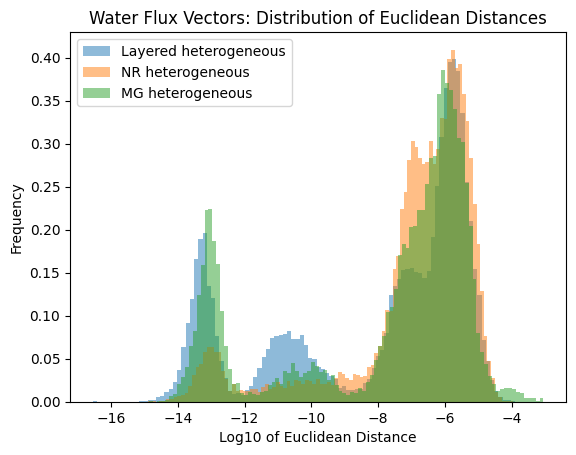

In [25]:
# plt.hist(np.log10(euclidean_distance_homo), alpha=.5, bins=100, label="Layered homogeneous", density=True)
plt.hist(np.log10(euclidean_distance_hetero), alpha=.5, bins=100, label="Layered heterogeneous", density=True)
# plt.hist(np.log10(euclidean_distance_archpy_homo), alpha=.5, bins=100, label="ArchPy homogeneous", density=True)
plt.hist(np.log10(euclidean_distance_new_res_hetero), alpha=.5, bins=100, label="NR heterogeneous", density=True)
plt.hist(np.log10(euclidean_distance_mg_he), alpha=.5, bins=100, label="MG heterogeneous", density=True)
plt.legend()
plt.xlabel("Log10 of Euclidean Distance")
plt.ylabel("Frequency")
plt.title("Water Flux Vectors: Distribution of Euclidean Distances")
plt.show()

In [26]:
# print mean euclidian distance
mean_euclidean_distance = {
    "Layered homogeneous": np.mean(euclidean_distance_homo),
    "Layered heterogeneous": np.mean(euclidean_distance_hetero),
    "ArchPy homogeneous": np.mean(euclidean_distance_archpy_homo),
    "New resolution heterogeneous": np.mean(euclidean_distance_new_res_hetero),
    "Modflow grid he": np.mean(euclidean_distance_mg_he)
}

for model, distance in mean_euclidean_distance.items():
    print(f"{model}: {distance:.3e} m3/s")

Layered homogeneous: 4.364e-06 m3/s
Layered heterogeneous: 1.641e-06 m3/s
ArchPy homogeneous: 4.169e-06 m3/s
New resolution heterogeneous: 1.990e-06 m3/s
Modflow grid he: 3.416e-06 m3/s


### Heads

In [27]:
sim= fp.mf6.MFSimulation.load(sim_name="sim_test",sim_ws="layered_hetero", verbosity_level=0)
gwf = sim.get_model("test")
head_lay_he = gwf.output.head().get_data()

sim= fp.mf6.MFSimulation.load(sim_name="sim_test",sim_ws="layered_homo", verbosity_level=0)
gwf = sim.get_model("test")
head_lay_ho = gwf.output.head().get_data()

sim= fp.mf6.MFSimulation.load(sim_name="sim_test",sim_ws="archpy_mode_hetero", verbosity_level=0)
gwf = sim.get_model("test")
head_ap_he = gwf.output.head().get_data()

# transform into averaged values per layer
l = []
for ilay in range(len(mask_units)):
    qx_copy = head_ap_he.copy()
    mask_lay = np.flipud(np.flip(mask_units[ilay], axis=1))
    qx_copy[~mask_lay] = np.nan
    qx_averaged = np.nanmean(qx_copy, axis=0)

    l.append(qx_averaged)
head_ap_he = np.array(l)

## AP HO
sim= fp.mf6.MFSimulation.load(sim_name="sim_test",sim_ws="archpy_mode_homo", verbosity_level=0)
gwf = sim.get_model("test")
head_ap_ho = gwf.output.head().get_data()

# transform into averaged values per layer
l = []
for ilay in range(len(mask_units)):
    qx_copy = head_ap_ho.copy()
    mask_lay = np.flipud(np.flip(mask_units[ilay], axis=1))
    qx_copy[~mask_lay] = np.nan
    qx_averaged = np.nanmean(qx_copy, axis=0)

    l.append(qx_averaged)
head_ap_ho = np.array(l)

## NR HE
sim= fp.mf6.MFSimulation.load(sim_name="sim_test",sim_ws="new_res_hetero", verbosity_level=0)
gwf = sim.get_model("test")
head_nr_he = gwf.output.head().get_data()

head_nr_he = load_prop(Table, mask_units, head_nr_he, 4, 2, 2)

In [28]:
sim= fp.mf6.MFSimulation.load(sim_name="sim_test",sim_ws="modflow_grid_hetero", verbosity_level=0)
gwf = sim.get_model("test")
modflow_grid = gwf.modelgrid
head_mg_he = gwf.output.head().get_data()

In [29]:
sim= fp.mf6.MFSimulation.load(sim_name="sim_test",sim_ws="archpy_mode_hetero", verbosity_level=0)
gwf = sim.get_model("test")
head_ap_he_org = gwf.output.head().get_data()
head_ap_he_upscaled = ArchPy.uppy.upscale_k(head_ap_he_org, dx=Table.sx, dy=Table.sy, dz=Table.sz, 
                                            ox=0, oy=0, oz=-15, 
                                            method="arithmetic", 
                                            grid=modflow_grid, scheme="center")[0].astype(float)

In [36]:
# default font size
matplotlib.rcParams.update({'font.size': 10})

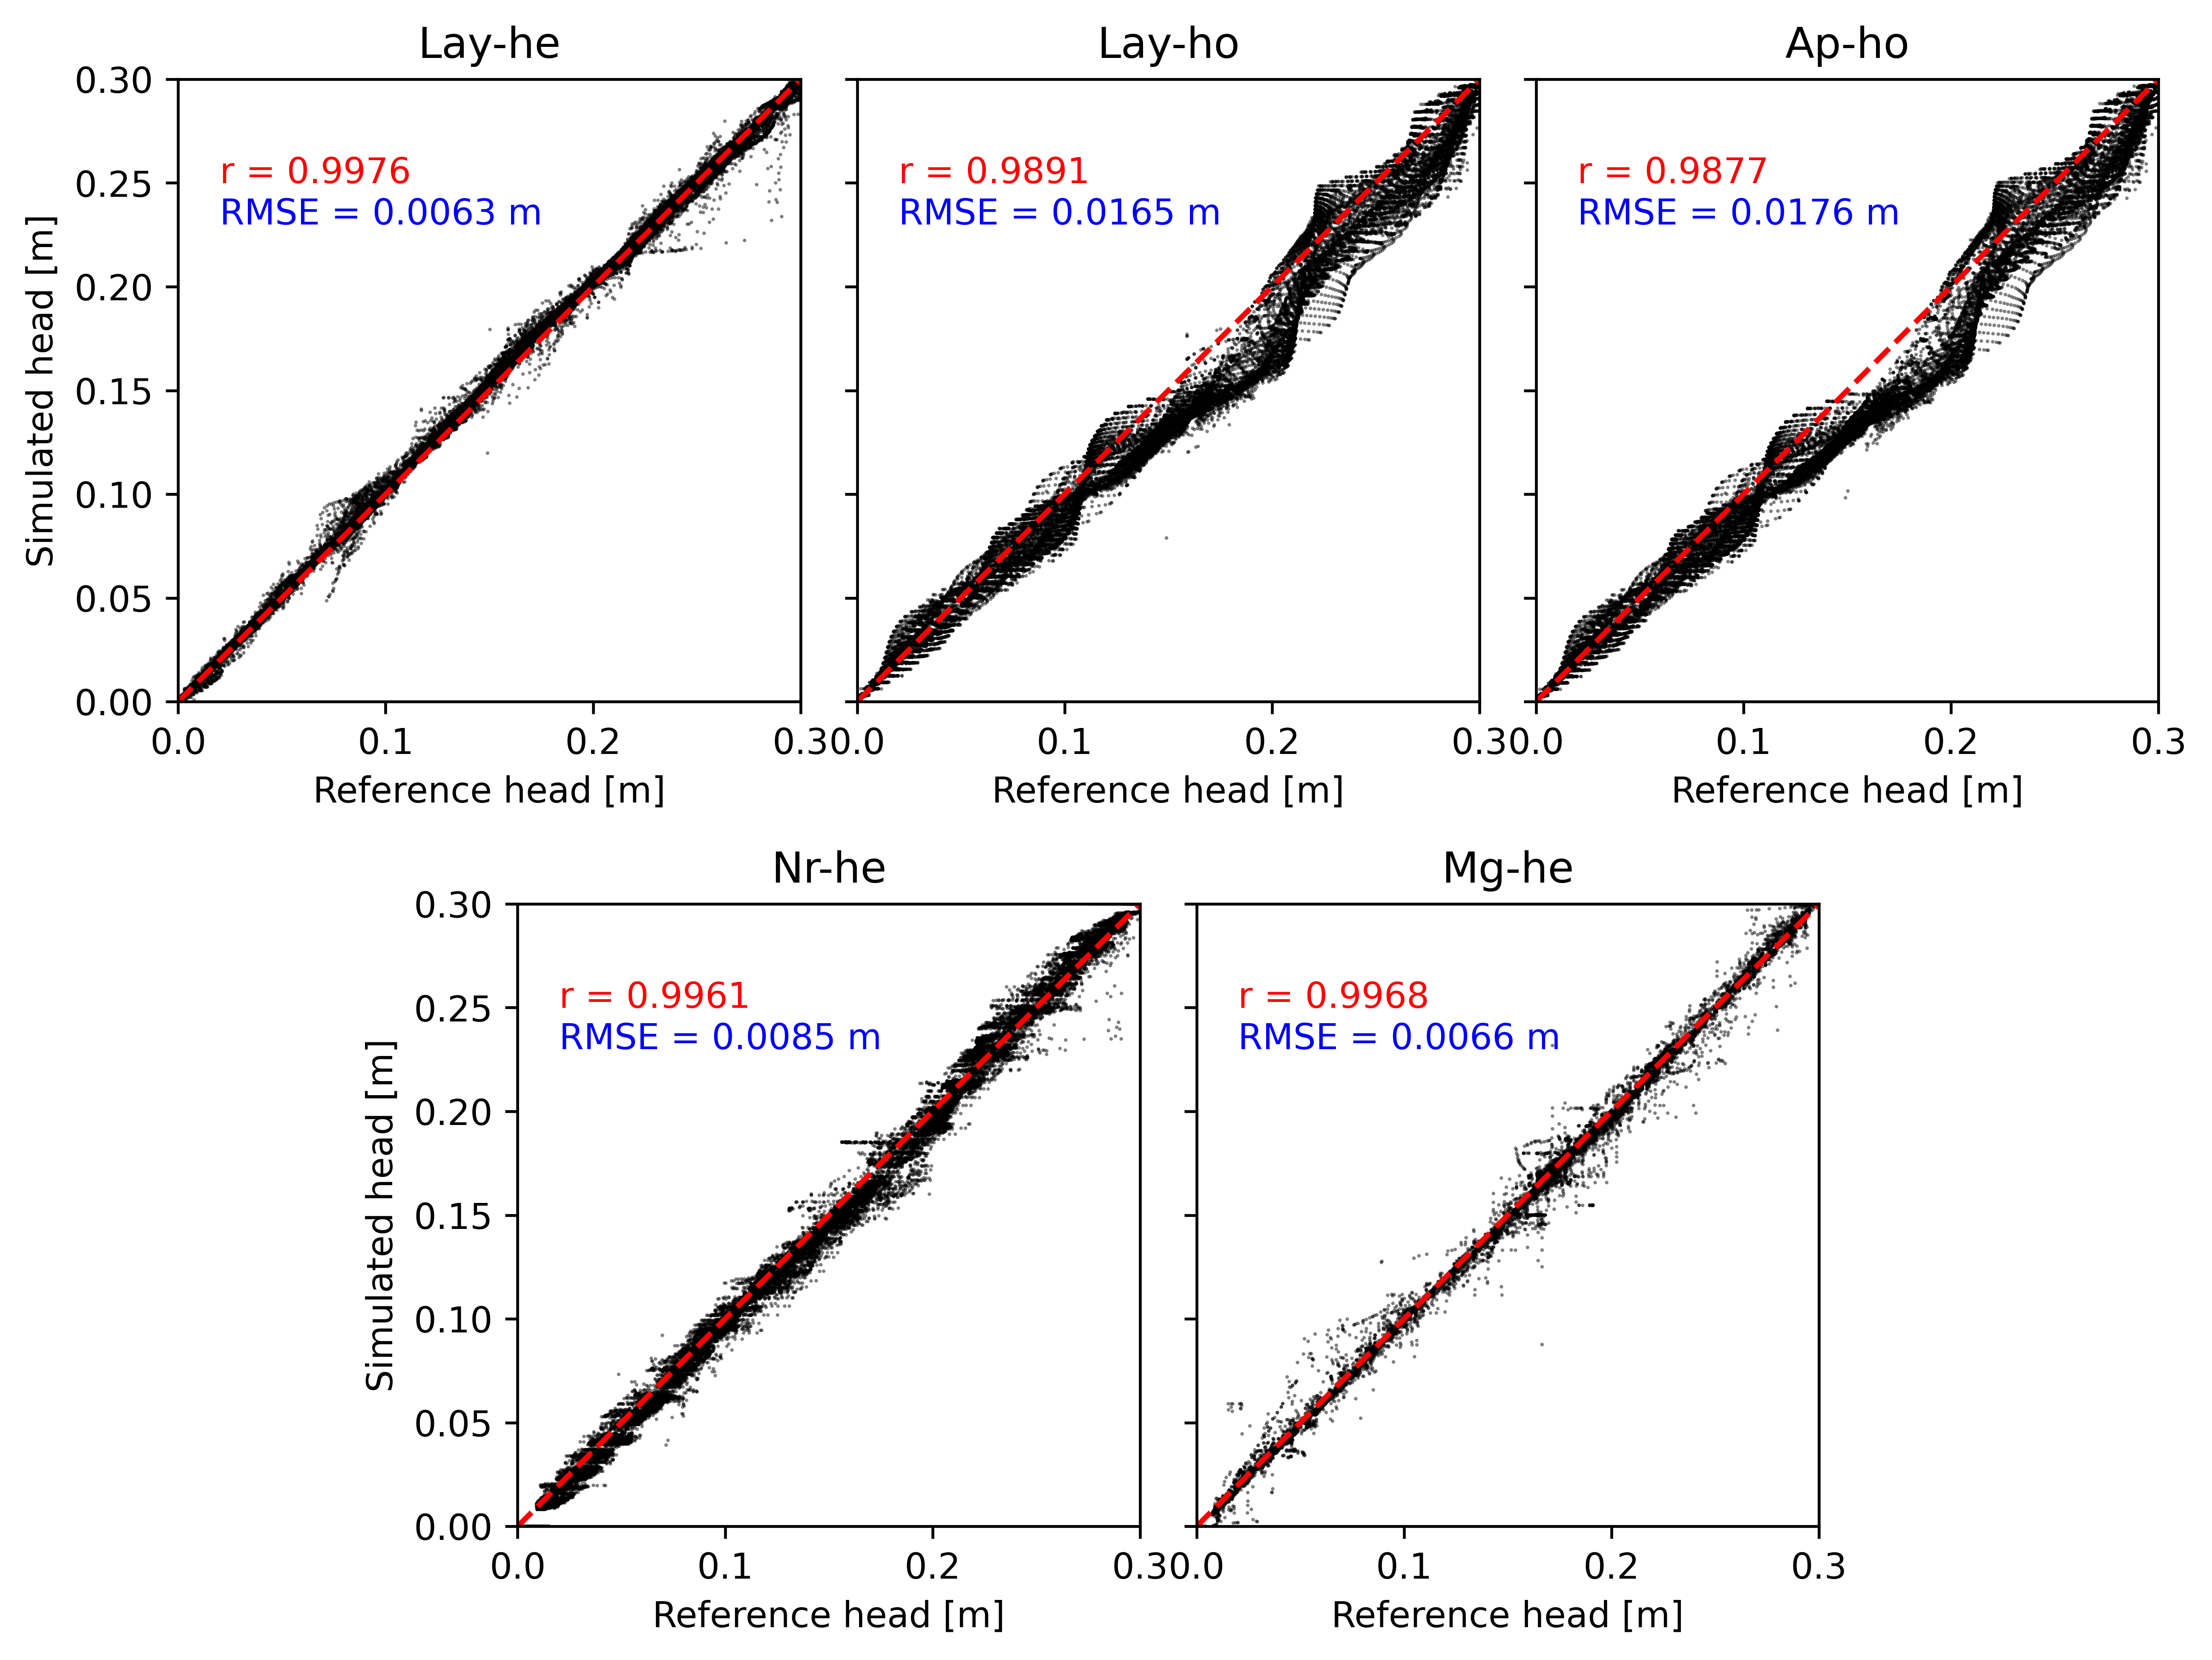

In [47]:
# fig,ax = plt.subplots(2, 3, figsize=(10, 6), dpi=600, sharex=True, sharey=True)

heads_ref = [head_ap_he, head_ap_he, head_ap_he, head_ap_he, head_ap_he_upscaled]
heads = [head_lay_he, head_lay_ho, head_ap_ho, head_nr_he, head_mg_he]
titles = ["Lay-he", "Lay-ho", "Ap-ho", "Nr-he", "Mg-he"]
cmap = "viridis"

fig = plt.figure(figsize=(10, 8), dpi=600) 
fig.subplots_adjust(wspace=.5, hspace=0.1)

gs = fig.add_gridspec(2, 12)
ax1 = fig.add_subplot(gs[0, 0:4])
ax2 = fig.add_subplot(gs[0, 4:8])
ax2.set_yticklabels([])
ax3 = fig.add_subplot(gs[0, 8:12])
ax3.set_yticklabels([])
ax4 = fig.add_subplot(gs[1, 2:6])
ax5 = fig.add_subplot(gs[1, 6:10])
ax5.set_yticklabels([])

axes = [ax1, ax2, ax3, ax4, ax5]

for i, head in enumerate(heads):

    axi = axes[i]

    h_ref = heads_ref[i].flatten()
    axi.scatter(h_ref, head.flatten(), s=1, c="black", alpha=0.5, edgecolors="none")
    axi.set_xlim(0, 0.3)
    axi.set_ylim(0, 0.3)
    axi.set_xlabel("Reference head [m]")
    if i == 0 or i == 3:
        axi.set_ylabel("Simulated head [m]")

    axi.set_title(titles[i])
    axi.set_aspect('equal', adjustable='box')

    # plot 1:1 line
    xlim = axi.get_xlim()
    ylim = axi.get_ylim()
    x = np.linspace(xlim[0], xlim[1], 100)
    y = np.linspace(ylim[0], ylim[1], 100)
    axi.plot(x, y, color="red", linestyle="--")

    # plot correlation coefficient
    h1 = h_ref.flatten()
    h2 = head.flatten()
    mask_nan = np.isnan(h1) | np.isnan(h2)
    h1 = h1[~mask_nan]
    h2 = h2[~mask_nan]
    corr = np.corrcoef(h1, h2)[0, 1]
    axi.text(0.02, 0.25, f"r = {corr:.4f}", color="red")

    # rmse
    rmse = np.sqrt(np.nanmean((h1 - h2) ** 2))
    axi.text(0.02, 0.23, f"RMSE = {rmse:.4f} m", color="blue")
    # plot colorbar
    axi.set_aspect('equal', adjustable='box')

fig.savefig("../../../figures/articles/archpy 2/raw/heads_scatter.png", dpi=300, bbox_inches="tight")